# CS4220 Project 2 - Pathogen Detection

In this notebook, we give an example to show how to read and use the DNA read data. We will train one base line model, using `sklearn.LogisticRegression`, and use it to predict the pathogens in each patient's dataset.

## Related python packages

To get started (if you are using python), you may want to create a virtual python environment and install some packages. Here are some of the commands you might need:

```bash
conda create --name cs4220 python=3.8

# Install jupyter notebook if you are using it
conda install -c anaconda ipykernel
python -m ipykernel install --user --name=cs4220
conda install -c anaconda jupyter

# Some common packages
conda install pandas                      # for reading csv
conda install scikit-learn                # for the logistic regression model
pip install pytorch                       # if you are using neural networks
conda install -c conda-forge matplotlib   # for plotting
conda install seaborn                     # also for plotting
pip install umap-learn[plot]              # plotting UMAP plots
conda install numpy                       # for many math/vectorized operations
```

In [1]:
# import packages

import numpy as np
import pandas as pd
import timeit
import time
import statistics 
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pickle as pkl
from umap.umap_ import UMAP
from joblib import dump, load
from itertools import chain
from typing import Union, Any

from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression

# Non-linear classifiers
from sklearn import svm # Should do with RBF or polynomial kernel
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier 
# Note OVR -- sensitive to imbalanced dataset, OVO is less sensitive
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import (NeighborhoodComponentsAnalysis, KNeighborsClassifier)

from utils.common import *
from utils.dataset import CS4220Dataset
from utils.feature_selection import *
from utils.model_evaluation import *

/Users/melloo21/opt/anaconda3/envs/cs4220_pathogen_detection/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import datashader as ds
import datashader.transfer_functions as tf
import datashader.bundling as bd
import colorcet
import matplotlib.cm
import bokeh.plotting as bpl
import bokeh.transform as btr
import holoviews as hv
import holoviews.operation.datashader as hd

import umap.plot
import torch
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader

/Users/melloo21/opt/anaconda3/envs/cs4220_pathogen_detection/lib/python3.8/site-packages/umap/plot.py:203: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit(nopython=False)


In [3]:
# Check the current working directory
%pwd

'/Users/melloo21/Desktop/NUS Items/CS4220/cs4220_project_2/cs4220-pathogen-detection'

## Testing Utils

In [26]:
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
def filtered_array(array, idx_to_drop):
    return np.take(array, idx_to_drop, axis=1)
  
def get_all_jaccard_index_with_filter( model:Any, label_encoder:Any , filtered_idx:Any, num_patients:int=10, threshold:float=0.95):

    all_jaccard_index = []
    all_pred = []
    all_true = []
    for patient_id in range(num_patients):
        print('predicting for patient {}'.format(patient_id))

        with open('test_data/patient{}_6mers.npy'.format(patient_id), 'rb') as read_file:
            df_test = np.load(read_file)

        # regr.predict relies on argmax, thus predict to every single read and you will end up with many false positives
        transformed_data = filtered_array(df_test,filtered_idx)
        print(f"Shape of {transformed_data.shape}")
        y_pred = model.predict(transformed_data)

        # we can use regr.predict_proba to find a good threshold and predict only for case where the model is confident.
        # here I apply 0.95 as the cutoff for my predictions, let's see how well my model will behave...
        y_predprob = model.predict_proba(transformed_data)

        # we get only predictions larger than the threshold and if there is more than one, we take the argmax again
        final_predictions = label_encoder.inverse_transform(
                                np.unique([np.argmax(item) for item in y_predprob if len(np.where(item >= threshold)[0]) >= 1]
                            ))

        # my pathogens dectected, decoy will be ignored
        final_predictions = [item for item in final_predictions if item !='decoy']

        ji, pred_pathogen, true_pathogen = jaccard_index_per_patient(patient_id, final_predictions)
        print('Jaccard index: {}'.format(ji))
        all_jaccard_index.append(ji)    
        all_pred.append(pred_pathogen)
        all_true.append(true_pathogen)

    return all_jaccard_index, flatten(all_pred), flatten(all_true)    

def print_full(x):
    pd.set_option('display.max_rows', len(x))
    print(x)
    pd.reset_option('display.max_rows')

def random_forest_selector(X,y):
    # Using feature importance to select features
    model = RandomForestClassifier(random_state=1, max_depth=10)
    model.fit(X,y)
    features = X.columns
    importances = model.feature_importances_
    # Create a dataframe for feature importance
    feature_importance_df = pd.DataFrame({"features": list(features) ,"importances": list(importances)} )
    indices = np.argsort(importances)[-9:]  # top 10 features
    plt.title('Feature Importances')
    plt.barh(range(len(indices)), importances[indices], color='b', align='center')
    plt.yticks(range(len(indices)), [features[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.show()

    return feature_importance_df

def create_coarse_labels(df):
    df['coarse_species_name'] = np.where(df['species_name'] != "decoy", "non_decoy", "decoy")
    le = preprocessing.LabelEncoder()
    le.fit(df['coarse_species_name'].unique())
    y_index = le.transform(df['coarse_species_name'].values)
    df['labels'] = y_index
    print(f"Unique labels {len(df['coarse_species_name'].unique())}")
    return df, le

def jaccard_index_per_patient(patient_id:str, preds):
    # Generic filename
    df_true = pd.read_csv('test_data/patient{}_labels.csv'.format(patient_id))
    tp, fp, tp_fn = 0, 0, df_true['labels'].shape[0]
    print('my predition(s) for patient {}:'.format(patient_id))
    print(preds)
    print('true pathogen')
    print(df_true['labels'].values)
    # if don't predict any pathogen, it means there is only decoy in the test dataset (your prediction)
    if len(preds) == 0:
        preds = ['decoy']
    for item in np.unique(preds):
        if item in df_true['labels'].values:
            tp += 1
        else:
            fp += 1
    #you have to predict all labels correctly, but you are penalized for any false positive
    return tp / (tp_fn + fp) , preds, df_true['labels'].values

def get_all_jaccard_index_with_transformation( model:Any, label_encoder:Any , x_transformer:Any, num_patients:int=10, threshold:float=0.95):

    all_jaccard_index = []
    all_pred = []
    all_true = []
    for patient_id in range(num_patients):
        print('predicting for patient {}'.format(patient_id))

        with open('test_data/patient{}_6mers.npy'.format(patient_id), 'rb') as read_file:
            df_test = np.load(read_file)

        # regr.predict relies on argmax, thus predict to every single read and you will end up with many false positives
        transformed_data =x_transformer.fit_transform(df_test)
        y_pred = model.predict(transformed_data)

        # we can use regr.predict_proba to find a good threshold and predict only for case where the model is confident.
        # here I apply 0.95 as the cutoff for my predictions, let's see how well my model will behave...
        y_predprob = model.predict_proba(transformed_data)

        # we get only predictions larger than the threshold and if there is more than one, we take the argmax again
        final_predictions = label_encoder.inverse_transform(
                                np.unique([np.argmax(item) for item in y_predprob if len(np.where(item >= threshold)[0]) >= 1]
                            ))
        
        # my pathogens dectected, decoy will be ignored
        final_predictions = [item for item in final_predictions if item !='decoy']

        print(f"final_predictions {final_predictions} , unique {np.unique(final_predictions)}")
        ji, pred_pathogen, true_pathogen = jaccard_index_per_patient(patient_id, final_predictions)
        print('Jaccard index: {}'.format(ji))
        all_jaccard_index.append(ji)    
        all_pred.append(pred_pathogen)
        all_true.append(true_pathogen)

    return all_jaccard_index, flatten(all_pred), flatten(all_true)

def flatten(original_list:list):
    return list(chain.from_iterable(original_list))

def get_kmer_analysis_map(dataset):
    test = dataset.X_mapped.copy()
    test["labels"] = dataset.Y   
    return test.groupby("labels").mean().reset_index()
    
def getting_no_kmer_existence(analysis):

    kmer_by_label = dict()
    # Obtaining the profile
    for elem in analysis.index:
        kmer_by_label[elem] = analysis.iloc[elem,1:-1]

    # Getting label without that kmer
    for elem in analysis.index:
        kmer_zero = list(kmer_by_label[elem][kmer_by_label[elem]==0].index)
        if (len(kmer_zero) > 0):
            print(f" label {elem} ::  {kmer_zero}")

    return kmer_zero

def get_label_by_kmer(kmer_analysis):
    label_profile_by_kmer = dict()

    # Obtaining the profile
    for elem in range(1,len(kmer_analysis.columns)-1):
        label_profile_by_kmer[kmer_analysis.columns[elem]] = kmer_analysis.iloc[:,elem]
    return label_profile_by_kmer

def get_std_across_labels_by_kmer(kmer_analysis):
    label_profile_by_kmer = get_label_by_kmer(kmer_analysis)

    std_accross_labels = dict()

    for key, values in label_profile_by_kmer.items():
        std_accross_labels[key] = np.std(values)

    # Sort by variation
    std_accross_labels_sorted = dict(sorted(std_accross_labels.items(), key=lambda item: item[1]))

    return std_accross_labels_sorted

## Parsing Input Data

First, some dataset statistics. We load our training labels (ground truth) and see how many reads a category (species) have.

In [5]:
label_df = pd.read_csv('./training_data/train_labels.csv')
get_species_count(label_df)

(461581,
 species_name
 decoy                              413476
 burkholderia_pseudomallei            3533
 pseudomonas_aeruginosa               3126
 klebsiella_michiganensis             2989
 mycobacterium_ulcerans               2910
 klebsiella_pneumoniae                2806
 serratia_liquefaciens                2629
 vibrio_parahaemolyticus              2579
 salmonella_enterica_typhimurium      2507
 yersinia_enterocolitica              2276
 stenotrophomonas_maltophilia         2217
 mycobacterium_tuberculosis           2175
 clostridioides_difficile             2007
 acinetobacter_baumannii              1964
 legionella_pneumophila               1753
 listeria_monocytogenes               1479
 staphylococcus_aureus                1384
 staphylococcus_pseudintermedius      1328
 corynebacterium_ulcerans             1266
 corynebacterium_diphtheriae          1194
 streptococcus_suis                   1092
 neisseria_gonorrhoeae                1087
 streptococcus_agalactiae      

In [14]:
coarse_label_df ,coarse_label_encoder = create_coarse_labels(label_df)

Unique labels 2


It seems that we have a lot of decoy reads (decoy means sequencing reads from human or commensal species).

In [6]:
# snippet to load the grouth truth training labels and normalize the label predictions.
# your trained model will predict in this space (26 classes - pathogens and decoy)
processed_label_df ,label_encoder = create_label_df(label_df)
#this label_df will have label index instead of the actual class value

Unique labels 26


We are not training using the full dataset to provide a quick baseline here. Thus, we subsampled so that each category has 500 reads. Up to you to come up with interesting training strategies to use your full training dataset (or even your own datasets)!

In [13]:
#500 here means that there are at most 500 per label class
# find ways to reduce the sample size as there are >10000 samples

samples_800_index = create_sampling_idx(label_df,replace=True, sample_num=800,random_state=1)
samples_3000_index = create_sampling_idx(label_df,replace=True, sample_num=3000,random_state=1)

display(len(samples_800_index))
display(len(samples_3000_index))

20800

78000

In this project, we try to use canonical $k$-mer profiles to represent each read in the input. Here, we are using $k=6$ and consequently 2081 features (including 1 feature `IGNORE` for ambiguous $k$-mer) for each read. Read [this reference](https://bioinfologics.github.io/post/2018/09/17/k-mer-counting-part-i-introduction/) for more information.

To help you save time, we implemented a utility class `CS4220Dataset` that can
- take in raw reads as input (`.fasta`, `.fa` files), and turn them into $k$-mer profiles, or
- take in $k$-mer profile as input (`.npy` files),
- allow you to sample data or create $k$-mer profile on the fly (during training) to save memory.

In [59]:
# Example usage
#input_file_path = './training_data/train_raw_reads.fasta'
input_file_path = './training_data/train_6mers.npy'

coarse_sampled_dataset = CS4220Dataset(data_file=input_file_path, label_df=coarse_label_df, samples_index=samples_500_index)
print(len(coarse_sampled_dataset.X[:, :-1]), len(coarse_sampled_dataset.X[:, :-1][0])) # each row represent the sequence and each featuere represent the unique k-mers profile and the values represent the frequencies to it; exclude the last col as that is ambiguous
print(len(coarse_sampled_dataset.Y))

NameError: name 'coarse_label_df' is not defined

In [14]:
# Example usage
#input_file_path = './training_data/train_raw_reads.fasta'
input_file_path = './training_data/train_6mers.npy'

sampled_dataset = CS4220Dataset(
    data_file=input_file_path, label_df=processed_label_df, samples_index=samples_800_index)
print(len(sampled_dataset.X[:, :-1]), len(sampled_dataset.X[:, :-1][0])) # each row represent the sequence and each featuere represent the unique k-mers profile and the values represent the frequencies to it; exclude the last col as that is ambiguous
print(len(sampled_dataset.Y))

20800 2080
20800


In [103]:
# Using all data
all_dataset = CS4220Dataset(data_file=input_file_path, label_df=processed_label_df)
print(len(all_dataset.X[:, :-1]), len(all_dataset.X[:, :-1][0])) # each row represent the sequence and each featuere represent the unique k-mers profile and the values represent the frequencies to it; exclude the last col as that is ambiguous
print(len(all_dataset.Y))

461581 2080
461581


## Individual Dataset Preparation

### Features by Std

In [119]:
# Getting all the low variation of mean kmer 
STD_DEV_THRESHOLD = 0.0003
# kmer_analysis = get_kmer_analysis_map(all_dataset)

# # For entire dataset
# getting_no_kmer_existence(kmer_analysis)
# std_accross_labels_sorted = get_std_across_labels_by_kmer(kmer_analysis)

# Tunable parameter
all_dataset_features_to_keep = [key for key, elem in std_accross_labels_sorted.items() if elem >  STD_DEV_THRESHOLD]
idx_keep_by_std_filter_0_0003 = sampled_dataset.X_mapped.columns.get_indexer(all_dataset_features_to_keep)

In [121]:
len(idx_keep_by_std_filter_0_0003)

673

In [116]:
# idx_keep_by_std_filter_0_0001
# idx_keep_by_std_filter_0_0002
# idx_keep_by_std_filter_0_0003
array_by_std_filter = np.take(sampled_dataset.X, idx_keep_by_std_filter, axis=1)
array_by_std_filter.shape

In [ ]:
std_accross_labels_sorted.keys()

### Features by Feature Importance

In [10]:
# NUMBER
NUMBER_TO_DROP = 1500
# NUMBER_TO_DROP = 1000
feature_impt = pd.read_csv("/Users/melloo21/Desktop/NUS Items/CS4220/cs4220_project_2/cs4220-pathogen-detection/assets/feature_impt.csv")
idx_keep_by_feature_impt_580= feature_impt.sort_values(by="importances").iloc[NUMBER_TO_DROP:-1].index
print(len(idx_keep_by_feature_impt_580))

580


In [142]:
len(idx_keep_by_feature_impt_580)

580

In [65]:
array_by_feature_impt = np.take(sampled_dataset.X, idx_keep_by_feature_impt, axis=1)

In [66]:
array_by_feature_impt.shape

(78000, 1080)

## RF Modelling

In [67]:
# feature impt set 
# idx_keep_by_feature_impt_1080
# idx_keep_by_feature_impt_1580
# idx_keep_by_feature_impt_880
# idx_keep_by_feature_impt_580

array_by_feature_impt = np.take(sampled_dataset.X, idx_keep_by_feature_impt, axis=1)
print("executing for this dataset" ,array_by_feature_impt.shape)
# Runnning for sampling rate of 800 and toggling feature set
starting_time = timeit.default_timer()

model = RandomForestClassifier(random_state=1, max_depth=12, n_estimators=300, verbose=1)
%timeit
# Train the model using the training sets
model.fit(array_by_feature_impt, sampled_dataset.Y)
dump(model, 'models/rf_feature_impt_filtered_1980.joblib')
print("Time taken :", timeit.default_timer() - starting_time)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:  1.7min
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:  6.4min


Time taken : 545.918405458


In [70]:
array_by_feature_impt.shape

(78000, 1080)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.3s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    6.0s


 Macro Precision :  0.99, Recall :  0.99, F1 :  0.99
 Micro Precision :  0.99, Recall :  0.99, F1 :  0.99


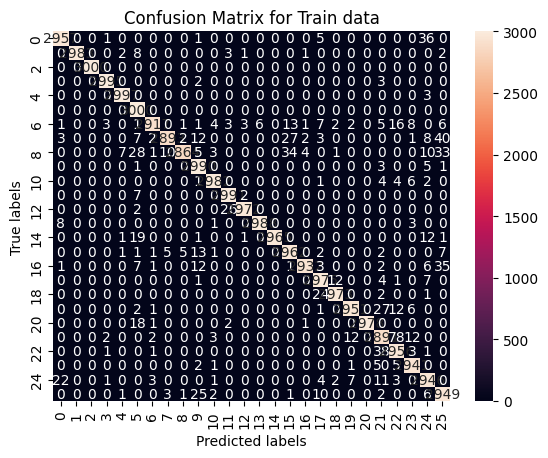

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.3s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    5.2s


 Macro Precision :  0.99, Recall :  0.99, F1 :  0.99
 Micro Precision :  0.99, Recall :  0.99, F1 :  0.99


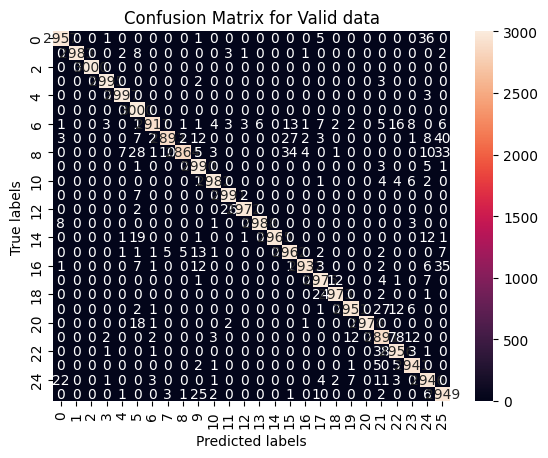

predicting for patient 0
Shape of (10054, 1080)


ValueError: X has 1080 features, but RandomForestClassifier is expecting 1937 features as input.

In [82]:
performance_evaluate(
    train_dataset=(array_by_feature_impt, sampled_dataset.Y),
    valid_dataset=(array_by_feature_impt, sampled_dataset.Y),
    model_name="rf_feature_impt_filtered_1980",
    filepath="models"
)

all_jaccard_index, all_pred, all_true = get_all_jaccard_index_with_filter(model=model, label_encoder=label_encoder,filtered_idx=idx_keep_by_feature_impt ,threshold=0.8)

print(['patient {}: {}'.format(c,item) for c, item in enumerate(all_jaccard_index)], 'avg: {}'.format(np.mean(all_jaccard_index)))

In [80]:
##### feature impt set Change param ####
# idx_keep_by_std_filter_0_0001
# idx_keep_by_std_filter_0_0002
# idx_keep_by_std_filter_0_0003

# array_by_std_filter = np.take(sampled_dataset.X, idx_keep_by_std_filter_0_0001, axis=1)
# array_by_std_filter.shape
# Runnning for sampling rate of 3000 and toggling std dev set
starting_time = timeit.default_timer()
print("executing for this dataset" ,array_by_std_filter.shape)

model = RandomForestClassifier(random_state=1, max_depth=12, n_estimators=300, verbose=1)
%timeit
# Train the model using the training sets
model.fit(array_by_std_filter, sampled_dataset.Y)
dump(model, 'models/rf_std_impt_filtered_1937.joblib')
print("Time taken :", timeit.default_timer() - starting_time)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:  2.3min
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:  8.8min


Time taken : 755.3280020419998


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    5.4s


 Macro Precision :  0.99, Recall :  0.99, F1 :  0.99
 Micro Precision :  0.99, Recall :  0.99, F1 :  0.99


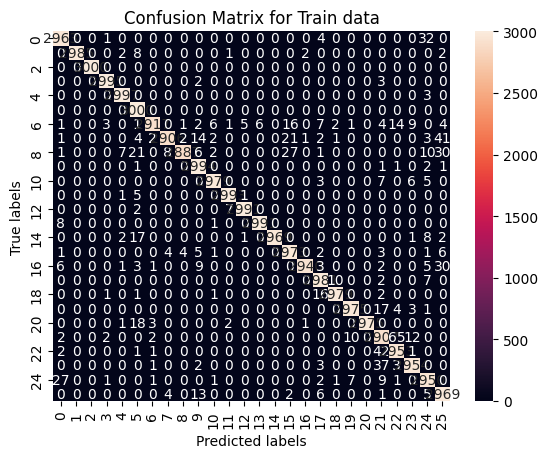

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.2s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    4.9s


 Macro Precision :  0.99, Recall :  0.99, F1 :  0.99
 Micro Precision :  0.99, Recall :  0.99, F1 :  0.99


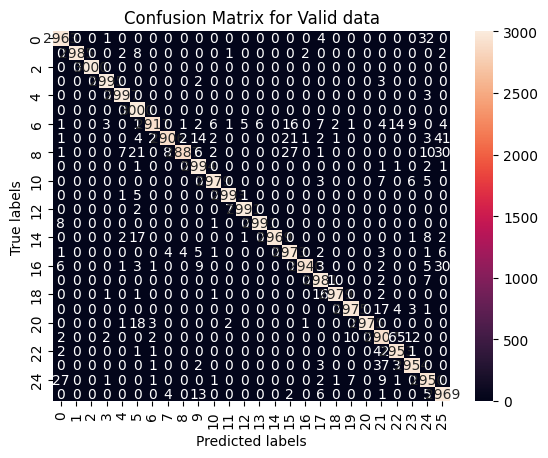

predicting for patient 0
Shape of (10054, 1937)


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.6s


my predition(s) for patient 0:
['staphylococcus_aureus']
true pathogen
['staphylococcus_aureus']
Jaccard index: 1.0
predicting for patient 1
Shape of (10132, 1937)


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.7s


my predition(s) for patient 1:
['neisseria_gonorrhoeae']
true pathogen
['staphylococcus_pyogenes']
Jaccard index: 0.0
predicting for patient 2
Shape of (10022, 1937)


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.6s


my predition(s) for patient 2:
['burkholderia_pseudomallei', 'clostridioides_difficile', 'corynebacterium_ulcerans']
true pathogen
['burkholderia_pseudomallei' 'corynebacterium_ulcerans']
Jaccard index: 0.6666666666666666
predicting for patient 3
Shape of (9984, 1937)


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.6s


my predition(s) for patient 3:
['pseudomonas_aeruginosa']
true pathogen
['pseudomonas_aeruginosa']
Jaccard index: 1.0
predicting for patient 4
Shape of (10086, 1937)


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.9s


my predition(s) for patient 4:
['corynebacterium_diphtheriae']
true pathogen
['corynebacterium_diphtheriae']
Jaccard index: 1.0
predicting for patient 5
Shape of (10046, 1937)


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.6s


my predition(s) for patient 5:
[]
true pathogen
['streptococcus_pneumoniae']
Jaccard index: 0.0
predicting for patient 6
Shape of (9974, 1937)


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.7s


my predition(s) for patient 6:
[]
true pathogen
['mycobacterium_ulcerans']
Jaccard index: 0.0
predicting for patient 7
Shape of (10046, 1937)


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.6s


my predition(s) for patient 7:
['neisseria_gonorrhoeae']
true pathogen
['mycobacterium_tuberculosis' 'streptococcus_pneumoniae']
Jaccard index: 0.0
predicting for patient 8
Shape of (10009, 1937)


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.6s


my predition(s) for patient 8:
[]
true pathogen
['streptococcus_pneumoniae']
Jaccard index: 0.0
predicting for patient 9
Shape of (10074, 1937)


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.7s


my predition(s) for patient 9:
['burkholderia_pseudomallei', 'neisseria_gonorrhoeae']
true pathogen
['burkholderia_pseudomallei']
Jaccard index: 0.5
['patient 0: 1.0', 'patient 1: 0.0', 'patient 2: 0.6666666666666666', 'patient 3: 1.0', 'patient 4: 1.0', 'patient 5: 0.0', 'patient 6: 0.0', 'patient 7: 0.0', 'patient 8: 0.0', 'patient 9: 0.5'] avg: 0.41666666666666663


In [88]:
performance_evaluate(
    train_dataset=(array_by_std_filter, sampled_dataset.Y),
    valid_dataset=(array_by_std_filter, sampled_dataset.Y),
    model_name="rf_std_impt_filtered_1937",
    filepath="models"
)

all_jaccard_index, all_pred, all_true = get_all_jaccard_index_with_filter(
    model=model,
    label_encoder=label_encoder,
    filtered_idx=idx_keep_by_std_filter ,
    threshold=0.6)

print(['patient {}: {}'.format(c,item) for c, item in enumerate(all_jaccard_index)], 'avg: {}'.format(np.mean(all_jaccard_index)))


## Logistic Regression with LR multinomial

In [33]:
# feature impt set 
# idx_keep_by_feature_impt_1080
# idx_keep_by_feature_impt_1580
# idx_keep_by_feature_impt_880
# idx_keep_by_feature_impt_580
filter_num = 1080
model_type = "lr_with_multi"

array_by_feature_impt = np.take(sampled_dataset.X, idx_keep_by_feature_impt_1080, axis=1)

print("executing for this dataset" ,array_by_feature_impt.shape)
# Runnning for sampling rate of 800 and toggling feature set
starting_time = timeit.default_timer()

model =LogisticRegression(C=100, penalty='l1', solver='saga', n_jobs=-1, class_weight='balanced', max_iter=300, verbose=1, multi_class="multinomial")
%timeit
# Train the model using the training sets
model.fit(array_by_feature_impt, sampled_dataset.Y)

model_name = f'{model_type}_feature_impt_filtered_{filter_num}.joblib'
dump(model, f"models/{model_name}")
print("Time taken :", timeit.default_timer() - starting_time)

executing for this dataset (20800, 1080)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 3, change: 0.20790805
Epoch 1, change: 1.00000000
Epoch 4, change: 0.14737103
Epoch 2, change: 0.35658139
Epoch 5, change: 0.11885135
Epoch 3, change: 0.20969040
Epoch 6, change: 0.09990922
Epoch 4, change: 0.15267571
Epoch 7, change: 0.08797556
Epoch 5, change: 0.12074241
Epoch 8, change: 0.07879461
Epoch 6, change: 0.10023307
Epoch 9, change: 0.06998775
Epoch 7, change: 0.08917090
Epoch 10, change: 0.06409180
Epoch 8, change: 0.07905589
Epoch 11, change: 0.05820150
Epoch 9, change: 0.07141008
Epoch 12, change: 0.05305411
Epoch 10, change: 0.06432121
Epoch 13, change: 0.04886448
Epoch 11, change: 0.05789893
Epoch 14, change: 0.04444618
Epoch 12, change: 0.05303625
Epoch 15, change: 0.04137286
Epoch 13, change: 0.04867401
Epoch 16, change: 0.03817969
Epoch 14, change: 0.04506354
Epoch 17, change: 0.03525235
Epoch 15, change: 0.04142935
Epoch 18, change: 0.03316923
Epoch 16, change: 0.03819991
Epoch 19, change: 0.03076617
Epoch 17, change: 0.03550350
Epoch 20, change: 0.02877698
E

 Macro Precision :  0.91, Recall :  0.91, F1 :  0.91
 Micro Precision :  0.91, Recall :  0.91, F1 :  0.91


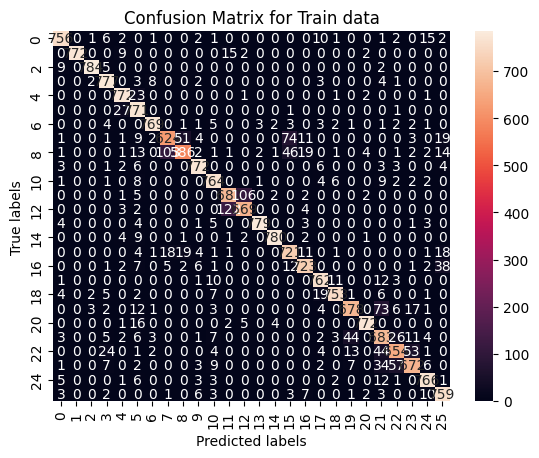

 Macro Precision :  0.91, Recall :  0.91, F1 :  0.91
 Micro Precision :  0.91, Recall :  0.91, F1 :  0.91


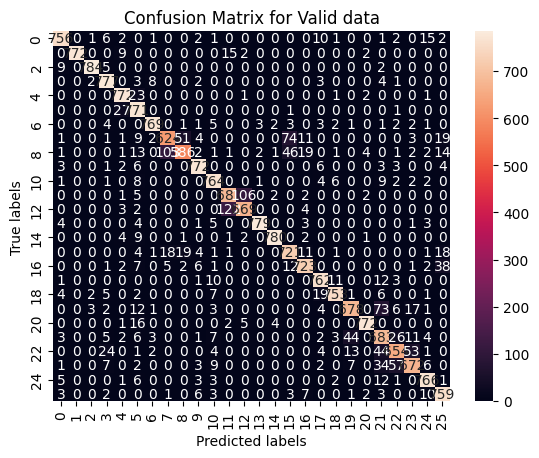

predicting for patient 0
Shape of (10054, 1080)
my predition(s) for patient 0:
['listeria_monocytogenes', 'staphylococcus_aureus', 'vibrio_parahaemolyticus']
true pathogen
['staphylococcus_aureus']
Jaccard index: 0.3333333333333333
predicting for patient 1
Shape of (10132, 1080)
my predition(s) for patient 1:
['listeria_monocytogenes', 'neisseria_gonorrhoeae', 'staphylococcus_pyogenes']
true pathogen
['staphylococcus_pyogenes']
Jaccard index: 0.3333333333333333
predicting for patient 2
Shape of (10022, 1080)
my predition(s) for patient 2:
['burkholderia_pseudomallei', 'clostridioides_difficile', 'corynebacterium_ulcerans']
true pathogen
['burkholderia_pseudomallei' 'corynebacterium_ulcerans']
Jaccard index: 0.6666666666666666
predicting for patient 3
Shape of (9984, 1080)
my predition(s) for patient 3:
['clostridioides_difficile', 'pseudomonas_aeruginosa', 'staphylococcus_pseudintermedius', 'yersinia_enterocolitica']
true pathogen
['pseudomonas_aeruginosa']
Jaccard index: 0.25
predicti

In [34]:
performance_evaluate(
    train_dataset=(array_by_feature_impt, sampled_dataset.Y),
    valid_dataset=(array_by_feature_impt, sampled_dataset.Y),
    model_name=model_name,
    filepath="models"
)

all_jaccard_index, all_pred, all_true = get_all_jaccard_index_with_filter(
    model=model, label_encoder=label_encoder,filtered_idx=idx_keep_by_feature_impt_1080 ,threshold=0.95)

print(['patient {}: {}'.format(c,item) for c, item in enumerate(all_jaccard_index)], 'avg: {}'.format(np.mean(all_jaccard_index)))

## OVR Modelling

In [157]:

# feature impt set 
# idx_keep_by_feature_impt_1080
# idx_keep_by_feature_impt_1580
# idx_keep_by_feature_impt_880
# idx_keep_by_feature_impt_580
filter_num = 580

array_by_feature_impt = np.take(sampled_dataset.X, idx_keep_by_feature_impt_580, axis=1)

print("executing for this dataset" ,array_by_feature_impt.shape)
# Runnning for sampling rate of 800 and toggling feature set
starting_time = timeit.default_timer()

model = OneVsRestClassifier(
    LogisticRegression(C=100, penalty='l1', solver='saga', n_jobs=-1, class_weight='balanced', max_iter=150, verbose=1)
    )

%timeit
# Train the model using the training sets
model.fit(array_by_feature_impt, sampled_dataset.Y) 
model_name = f'ovr_feature_impt_filtered_{filter_num}.joblib'
dump(model, f"models/{model_name}")
print("Time taken :", timeit.default_timer() - starting_time)

executing for this dataset (20800, 580)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.31836736
Epoch 3, change: 0.17005831
Epoch 4, change: 0.12904742
Epoch 5, change: 0.11788265
Epoch 6, change: 0.08546010
Epoch 7, change: 0.09240600
Epoch 8, change: 0.07786364
Epoch 9, change: 0.07320295
Epoch 10, change: 0.07358693
Epoch 11, change: 0.06375593
Epoch 12, change: 0.05992830
Epoch 13, change: 0.05938757
Epoch 14, change: 0.05306821
Epoch 15, change: 0.04608867
Epoch 16, change: 0.04975686
Epoch 17, change: 0.04465011
Epoch 18, change: 0.03828230
Epoch 19, change: 0.04224917
Epoch 20, change: 0.03760999
Epoch 21, change: 0.04082076
Epoch 22, change: 0.03383193
Epoch 23, change: 0.03357861
Epoch 24, change: 0.03007062
Epoch 25, change: 0.02533795
Epoch 26, change: 0.03141454
Epoch 27, change: 0.02499678
Epoch 28, change: 0.02553034
Epoch 29, change: 0.02548666
Epoch 30, change: 0.02342523
Epoch 31, change: 0.02108748
Epoch 32, change: 0.02129514
Epoch 33, change: 0.02044423
Epoch 34, change: 0.01917524
Epoch 35, change: 0.021

/Users/melloo21/opt/anaconda3/envs/cs4220_pathogen_detection/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.28772085
Epoch 3, change: 0.17692027
Epoch 4, change: 0.14981353
Epoch 5, change: 0.12392573
Epoch 6, change: 0.09914772
Epoch 7, change: 0.07970220
Epoch 8, change: 0.07899467
Epoch 9, change: 0.07045138
Epoch 10, change: 0.05609816
Epoch 11, change: 0.05140926
Epoch 12, change: 0.04935240
Epoch 13, change: 0.03718007
Epoch 14, change: 0.03636172
Epoch 15, change: 0.03689927
Epoch 16, change: 0.03272029
Epoch 17, change: 0.02537368
Epoch 18, change: 0.02441151
Epoch 19, change: 0.02325569
Epoch 20, change: 0.02030854
Epoch 21, change: 0.02462595
Epoch 22, change: 0.01846737
Epoch 23, change: 0.01939907
Epoch 24, change: 0.01872896
Epoch 25, change: 0.01523175
Epoch 26, change: 0.01406812
Epoch 27, change: 0.00916113
Epoch 28, change: 0.01228913
Epoch 29, change: 0.01061912
Epoch 30, change: 0.01289635
Epoch 31, change: 0.01177948
Epoch 32, change: 0.01106167
Epoch 33, change: 0.00859810
Epoch 34, change: 0.00876186
Epoch 35, change: 0.008

/Users/melloo21/opt/anaconda3/envs/cs4220_pathogen_detection/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.29197199
Epoch 3, change: 0.16977270
Epoch 4, change: 0.12113956
Epoch 5, change: 0.10367410
Epoch 6, change: 0.08001209
Epoch 7, change: 0.07943208
Epoch 8, change: 0.06624278
Epoch 9, change: 0.05968983
Epoch 10, change: 0.05015502
Epoch 11, change: 0.04557763
Epoch 12, change: 0.04724989
Epoch 13, change: 0.04091300
Epoch 14, change: 0.03564307
Epoch 15, change: 0.03586041
Epoch 16, change: 0.03633386
Epoch 17, change: 0.03354408
Epoch 18, change: 0.03053751
Epoch 19, change: 0.02432300
Epoch 20, change: 0.02705868
Epoch 21, change: 0.02142460
Epoch 22, change: 0.02260087
Epoch 23, change: 0.01909428
Epoch 24, change: 0.01975325
Epoch 25, change: 0.01778522
Epoch 26, change: 0.01877143
Epoch 27, change: 0.01706242
Epoch 28, change: 0.01519294
Epoch 29, change: 0.01275908
Epoch 30, change: 0.01569317
Epoch 31, change: 0.01154133
Epoch 32, change: 0.01223405
Epoch 33, change: 0.01140128
Epoch 34, change: 0.01105839
Epoch 35, change: 0.012

/Users/melloo21/opt/anaconda3/envs/cs4220_pathogen_detection/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.32056300
Epoch 3, change: 0.19124146
Epoch 4, change: 0.12354598
Epoch 5, change: 0.10442683
Epoch 6, change: 0.08003670
Epoch 7, change: 0.07683443
Epoch 8, change: 0.07912223
Epoch 9, change: 0.07391483
Epoch 10, change: 0.05479826
Epoch 11, change: 0.05472649
Epoch 12, change: 0.05057214
Epoch 13, change: 0.04604888
Epoch 14, change: 0.04494809
Epoch 15, change: 0.04022717
Epoch 16, change: 0.03973820
Epoch 17, change: 0.03484331
Epoch 18, change: 0.03243503
Epoch 19, change: 0.03124563
Epoch 20, change: 0.02864255
Epoch 21, change: 0.02648039
Epoch 22, change: 0.02321558
Epoch 23, change: 0.02431023
Epoch 24, change: 0.02145899
Epoch 25, change: 0.02131313
Epoch 26, change: 0.02130075
Epoch 27, change: 0.01783816
Epoch 28, change: 0.01870027
Epoch 29, change: 0.01527243
Epoch 30, change: 0.01512363
Epoch 31, change: 0.01525970
Epoch 32, change: 0.01714826
Epoch 33, change: 0.01416213
Epoch 34, change: 0.01296096
Epoch 35, change: 0.011

/Users/melloo21/opt/anaconda3/envs/cs4220_pathogen_detection/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.36027238
Epoch 3, change: 0.19366809
Epoch 4, change: 0.14269259
Epoch 5, change: 0.11112714
Epoch 6, change: 0.08845188
Epoch 7, change: 0.08342490
Epoch 8, change: 0.06942466
Epoch 9, change: 0.05966285
Epoch 10, change: 0.05681257
Epoch 11, change: 0.04761982
Epoch 12, change: 0.04662241
Epoch 13, change: 0.04310367
Epoch 14, change: 0.03875450
Epoch 15, change: 0.03434716
Epoch 16, change: 0.03084714
Epoch 17, change: 0.03011843
Epoch 18, change: 0.02810892
Epoch 19, change: 0.02667886
Epoch 20, change: 0.02223119
Epoch 21, change: 0.02259458
Epoch 22, change: 0.02131215
Epoch 23, change: 0.01710190
Epoch 24, change: 0.01833282
Epoch 25, change: 0.01769112
Epoch 26, change: 0.01785768
Epoch 27, change: 0.01777066
Epoch 28, change: 0.01753278
Epoch 29, change: 0.01662379
Epoch 30, change: 0.01651375
Epoch 31, change: 0.01405257
Epoch 32, change: 0.01544629
Epoch 33, change: 0.01346311
Epoch 34, change: 0.01395394
Epoch 35, change: 0.013

/Users/melloo21/opt/anaconda3/envs/cs4220_pathogen_detection/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.37100286
Epoch 3, change: 0.19677196
Epoch 4, change: 0.14247075
Epoch 5, change: 0.11485216
Epoch 6, change: 0.09459174
Epoch 7, change: 0.07777375
Epoch 8, change: 0.07941706
Epoch 9, change: 0.06015739
Epoch 10, change: 0.05079793
Epoch 11, change: 0.04522936
Epoch 12, change: 0.04621508
Epoch 13, change: 0.04214535
Epoch 14, change: 0.03859683
Epoch 15, change: 0.03656450
Epoch 16, change: 0.03655512
Epoch 17, change: 0.03222031
Epoch 18, change: 0.03041737
Epoch 19, change: 0.02718252
Epoch 20, change: 0.02632932
Epoch 21, change: 0.02379282
Epoch 22, change: 0.02383897
Epoch 23, change: 0.02105122
Epoch 24, change: 0.01960812
Epoch 25, change: 0.01981150
Epoch 26, change: 0.02025668
Epoch 27, change: 0.01950324
Epoch 28, change: 0.01743139
Epoch 29, change: 0.01524771
Epoch 30, change: 0.01695173
Epoch 31, change: 0.01392539
Epoch 32, change: 0.01359524
Epoch 33, change: 0.01293594
Epoch 34, change: 0.01258900
Epoch 35, change: 0.013

/Users/melloo21/opt/anaconda3/envs/cs4220_pathogen_detection/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.32114886
Epoch 3, change: 0.18432264
Epoch 4, change: 0.15971839
Epoch 5, change: 0.11421163
Epoch 6, change: 0.08695158
Epoch 7, change: 0.08646499
Epoch 8, change: 0.07608002
Epoch 9, change: 0.05714559
Epoch 10, change: 0.05292246
Epoch 11, change: 0.03922550
Epoch 12, change: 0.04177765
Epoch 13, change: 0.02367932
Epoch 14, change: 0.03964135
Epoch 15, change: 0.03608688
Epoch 16, change: 0.04607985
Epoch 17, change: 0.03441280
Epoch 18, change: 0.03950049
Epoch 19, change: 0.02869945
Epoch 20, change: 0.03587195
Epoch 21, change: 0.03278594
Epoch 22, change: 0.02357957
Epoch 23, change: 0.02771277
Epoch 24, change: 0.01813408
Epoch 25, change: 0.01312658
Epoch 26, change: 0.02963998
Epoch 27, change: 0.02970353
Epoch 28, change: 0.01759150
Epoch 29, change: 0.01921553
Epoch 30, change: 0.02324866
Epoch 31, change: 0.01272294
Epoch 32, change: 0.01756200
Epoch 33, change: 0.02139622
Epoch 34, change: 0.00902581
Epoch 35, change: 0.014

/Users/melloo21/opt/anaconda3/envs/cs4220_pathogen_detection/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.32352525
Epoch 3, change: 0.20694923
Epoch 4, change: 0.13909357
Epoch 5, change: 0.11798756
Epoch 6, change: 0.09655196
Epoch 7, change: 0.07711994
Epoch 8, change: 0.07522587
Epoch 9, change: 0.05696232
Epoch 10, change: 0.05701503
Epoch 11, change: 0.05468535
Epoch 12, change: 0.04818025
Epoch 13, change: 0.04563957
Epoch 14, change: 0.03448842
Epoch 15, change: 0.03684775
Epoch 16, change: 0.02924511
Epoch 17, change: 0.02477603
Epoch 18, change: 0.03058871
Epoch 19, change: 0.03299615
Epoch 20, change: 0.02823164
Epoch 21, change: 0.03062334
Epoch 22, change: 0.02036421
Epoch 23, change: 0.02054636
Epoch 24, change: 0.02527547
Epoch 25, change: 0.01837051
Epoch 26, change: 0.02017060
Epoch 27, change: 0.02187637
Epoch 28, change: 0.01941027
Epoch 29, change: 0.02247483
Epoch 30, change: 0.02454892
Epoch 31, change: 0.01652393
Epoch 32, change: 0.01481295
Epoch 33, change: 0.01595818
Epoch 34, change: 0.01417429
Epoch 35, change: 0.013

/Users/melloo21/opt/anaconda3/envs/cs4220_pathogen_detection/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.33948580
Epoch 3, change: 0.20185940
Epoch 4, change: 0.14258311
Epoch 5, change: 0.11274878
Epoch 6, change: 0.08822051
Epoch 7, change: 0.08681448
Epoch 8, change: 0.06628614
Epoch 9, change: 0.06648304
Epoch 10, change: 0.05166324
Epoch 11, change: 0.05730379
Epoch 12, change: 0.05455013
Epoch 13, change: 0.03575494
Epoch 14, change: 0.04455257
Epoch 15, change: 0.03905794
Epoch 16, change: 0.03163820
Epoch 17, change: 0.03450346
Epoch 18, change: 0.03527544
Epoch 19, change: 0.03204986
Epoch 20, change: 0.02533866
Epoch 21, change: 0.02548020
Epoch 22, change: 0.02507089
Epoch 23, change: 0.02884616
Epoch 24, change: 0.02149834
Epoch 25, change: 0.02237974
Epoch 26, change: 0.01883537
Epoch 27, change: 0.02052798
Epoch 28, change: 0.01663164
Epoch 29, change: 0.02256004
Epoch 30, change: 0.02031107
Epoch 31, change: 0.01947513
Epoch 32, change: 0.01185551
Epoch 33, change: 0.01763078
Epoch 34, change: 0.01890079
Epoch 35, change: 0.020

/Users/melloo21/opt/anaconda3/envs/cs4220_pathogen_detection/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.35513540
Epoch 3, change: 0.21856716
Epoch 4, change: 0.15407606
Epoch 5, change: 0.11613309
Epoch 6, change: 0.10933688
Epoch 7, change: 0.08357938
Epoch 8, change: 0.08154878
Epoch 9, change: 0.07949644
Epoch 10, change: 0.06068296
Epoch 11, change: 0.06354340
Epoch 12, change: 0.04765906
Epoch 13, change: 0.04351999
Epoch 14, change: 0.04422201
Epoch 15, change: 0.03643674
Epoch 16, change: 0.03501933
Epoch 17, change: 0.03815157
Epoch 18, change: 0.04091667
Epoch 19, change: 0.03381386
Epoch 20, change: 0.03722875
Epoch 21, change: 0.02634804
Epoch 22, change: 0.02643436
Epoch 23, change: 0.03107569
Epoch 24, change: 0.02568515
Epoch 25, change: 0.02155783
Epoch 26, change: 0.02258743
Epoch 27, change: 0.02764689
Epoch 28, change: 0.02494157
Epoch 29, change: 0.02275438
Epoch 30, change: 0.02184096
Epoch 31, change: 0.02078351
Epoch 32, change: 0.01659182
Epoch 33, change: 0.01714076
Epoch 34, change: 0.01562564
Epoch 35, change: 0.020

/Users/melloo21/opt/anaconda3/envs/cs4220_pathogen_detection/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.27528697
Epoch 3, change: 0.16617100
Epoch 4, change: 0.14742546
Epoch 5, change: 0.12545302
Epoch 6, change: 0.10176083
Epoch 7, change: 0.09394719
Epoch 8, change: 0.08092779
Epoch 9, change: 0.07354216
Epoch 10, change: 0.08058867
Epoch 11, change: 0.07228061
Epoch 12, change: 0.06852414
Epoch 13, change: 0.05536981
Epoch 14, change: 0.05204219
Epoch 15, change: 0.05551852
Epoch 16, change: 0.04242753
Epoch 17, change: 0.04443090
Epoch 18, change: 0.04324563
Epoch 19, change: 0.03703113
Epoch 20, change: 0.03799441
Epoch 21, change: 0.03143890
Epoch 22, change: 0.03353123
Epoch 23, change: 0.03048994
Epoch 24, change: 0.02817401
Epoch 25, change: 0.02669035
Epoch 26, change: 0.03280661
Epoch 27, change: 0.02893781
Epoch 28, change: 0.02672807
Epoch 29, change: 0.02462900
Epoch 30, change: 0.02390031
Epoch 31, change: 0.02589862
Epoch 32, change: 0.02429344
Epoch 33, change: 0.01730602
Epoch 34, change: 0.01902302
Epoch 35, change: 0.018

/Users/melloo21/opt/anaconda3/envs/cs4220_pathogen_detection/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.28875368
Epoch 3, change: 0.16847901
Epoch 4, change: 0.11048254
Epoch 5, change: 0.12741434
Epoch 6, change: 0.06715411
Epoch 7, change: 0.06855708
Epoch 8, change: 0.06942290
Epoch 9, change: 0.03645990
Epoch 10, change: 0.03275776
Epoch 11, change: 0.05122329
Epoch 12, change: 0.03184987
Epoch 13, change: 0.03249681
Epoch 14, change: 0.04096837
Epoch 15, change: 0.02966812
Epoch 16, change: 0.02686556
Epoch 17, change: 0.02783853
Epoch 18, change: 0.02565065
Epoch 19, change: 0.02818387
Epoch 20, change: 0.02862463
Epoch 21, change: 0.02585096
Epoch 22, change: 0.02605494
Epoch 23, change: 0.02767975
Epoch 24, change: 0.02663007
Epoch 25, change: 0.02236317
Epoch 26, change: 0.02486561
Epoch 27, change: 0.02381152
Epoch 28, change: 0.02212112
Epoch 29, change: 0.02319200
Epoch 30, change: 0.02104536
Epoch 31, change: 0.02173161
Epoch 32, change: 0.02052363
Epoch 33, change: 0.02009446
Epoch 34, change: 0.02123988
Epoch 35, change: 0.019

/Users/melloo21/opt/anaconda3/envs/cs4220_pathogen_detection/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.29024224
Epoch 3, change: 0.15094596
Epoch 4, change: 0.10677216
Epoch 5, change: 0.09987857
Epoch 6, change: 0.06343703
Epoch 7, change: 0.06998402
Epoch 8, change: 0.05809904
Epoch 9, change: 0.04412289
Epoch 10, change: 0.04174445
Epoch 11, change: 0.04801127
Epoch 12, change: 0.03822057
Epoch 13, change: 0.03882431
Epoch 14, change: 0.03714444
Epoch 15, change: 0.03395420
Epoch 16, change: 0.03361477
Epoch 17, change: 0.03826069
Epoch 18, change: 0.03125784
Epoch 19, change: 0.03354761
Epoch 20, change: 0.03535443
Epoch 21, change: 0.02857752
Epoch 22, change: 0.02778005
Epoch 23, change: 0.02959137
Epoch 24, change: 0.03061632
Epoch 25, change: 0.02832002
Epoch 26, change: 0.02665229
Epoch 27, change: 0.02568442
Epoch 28, change: 0.02142251
Epoch 29, change: 0.02298345
Epoch 30, change: 0.02723912
Epoch 31, change: 0.02503346
Epoch 32, change: 0.02190474
Epoch 33, change: 0.02354498
Epoch 34, change: 0.02258207
Epoch 35, change: 0.023

/Users/melloo21/opt/anaconda3/envs/cs4220_pathogen_detection/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.37707521
Epoch 3, change: 0.22215072
Epoch 4, change: 0.15436723
Epoch 5, change: 0.12672955
Epoch 6, change: 0.09843113
Epoch 7, change: 0.08836642
Epoch 8, change: 0.07748848
Epoch 9, change: 0.06823390
Epoch 10, change: 0.06056833
Epoch 11, change: 0.05346719
Epoch 12, change: 0.05341434
Epoch 13, change: 0.04559031
Epoch 14, change: 0.04949666
Epoch 15, change: 0.04161607
Epoch 16, change: 0.03903845
Epoch 17, change: 0.03207844
Epoch 18, change: 0.03092356
Epoch 19, change: 0.03288903
Epoch 20, change: 0.03145085
Epoch 21, change: 0.03142954
Epoch 22, change: 0.02458087
Epoch 23, change: 0.02370850
Epoch 24, change: 0.02298874
Epoch 25, change: 0.02483388
Epoch 26, change: 0.02308067
Epoch 27, change: 0.02023745
Epoch 28, change: 0.01776423
Epoch 29, change: 0.02115226
Epoch 30, change: 0.01715653
Epoch 31, change: 0.01822404
Epoch 32, change: 0.01953763
Epoch 33, change: 0.01908465
Epoch 34, change: 0.01660519
Epoch 35, change: 0.014

/Users/melloo21/opt/anaconda3/envs/cs4220_pathogen_detection/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.30301720
Epoch 3, change: 0.19058758
Epoch 4, change: 0.14521872
Epoch 5, change: 0.11943942
Epoch 6, change: 0.10130795
Epoch 7, change: 0.07454957
Epoch 8, change: 0.07522477
Epoch 9, change: 0.06483135
Epoch 10, change: 0.06088803
Epoch 11, change: 0.05286362
Epoch 12, change: 0.05432297
Epoch 13, change: 0.05242957
Epoch 14, change: 0.04168769
Epoch 15, change: 0.04137983
Epoch 16, change: 0.03254526
Epoch 17, change: 0.03700861
Epoch 18, change: 0.02830503
Epoch 19, change: 0.02950451
Epoch 20, change: 0.02770339
Epoch 21, change: 0.03034769
Epoch 22, change: 0.02525997
Epoch 23, change: 0.02277528
Epoch 24, change: 0.02157282
Epoch 25, change: 0.02538229
Epoch 26, change: 0.02166314
Epoch 27, change: 0.02681988
Epoch 28, change: 0.02104230
Epoch 29, change: 0.01867472
Epoch 30, change: 0.01857307
Epoch 31, change: 0.02078679
Epoch 32, change: 0.01689933
Epoch 33, change: 0.01602994
Epoch 34, change: 0.01535260
Epoch 35, change: 0.017

/Users/melloo21/opt/anaconda3/envs/cs4220_pathogen_detection/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 2, change: 0.37280798
Epoch 3, change: 0.21686109
Epoch 4, change: 0.16741913
Epoch 5, change: 0.13612439
Epoch 6, change: 0.11963822
Epoch 7, change: 0.08420567
Epoch 8, change: 0.08145159
Epoch 9, change: 0.06435523
Epoch 10, change: 0.06914219
Epoch 11, change: 0.05200196
Epoch 12, change: 0.05124974
Epoch 13, change: 0.04632818
Epoch 14, change: 0.04297517
Epoch 15, change: 0.04125729
Epoch 16, change: 0.04161592
Epoch 17, change: 0.03362363
Epoch 18, change: 0.03353836
Epoch 19, change: 0.03206961
Epoch 20, change: 0.03014337
Epoch 21, change: 0.02341905
Epoch 22, change: 0.02847155
Epoch 23, change: 0.02544792
Epoch 24, change: 0.02561442
Epoch 25, change: 0.02818416
Epoch 26, change: 0.01763449
Epoch 27, change: 0.02183432
Epoch 28, change: 0.01965803
Epoch 29, change: 0.02119326
Epoch 30, change: 0.02063518
Epoch 31, change: 0.01798442
Epoch 32, change: 0.01773479
Epoch 33, change: 0.01643676
Epoch 34, change: 0.01748837
Epoch 35, change: 0.01426000
Epoch 36, change: 0.01

/Users/melloo21/opt/anaconda3/envs/cs4220_pathogen_detection/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.32469595
Epoch 3, change: 0.18642753
Epoch 4, change: 0.12879140
Epoch 5, change: 0.11316144
Epoch 6, change: 0.09348564
Epoch 7, change: 0.08245175
Epoch 8, change: 0.08471859
Epoch 9, change: 0.07011403
Epoch 10, change: 0.06709256
Epoch 11, change: 0.05881191
Epoch 12, change: 0.06079341
Epoch 13, change: 0.05169088
Epoch 14, change: 0.04635734
Epoch 15, change: 0.05000696
Epoch 16, change: 0.04952103
Epoch 17, change: 0.04224134
Epoch 18, change: 0.03421216
Epoch 19, change: 0.03844293
Epoch 20, change: 0.03257923
Epoch 21, change: 0.03256083
Epoch 22, change: 0.02953097
Epoch 23, change: 0.03035678
Epoch 24, change: 0.02817647
Epoch 25, change: 0.03050879
Epoch 26, change: 0.02755629
Epoch 27, change: 0.02332753
Epoch 28, change: 0.02511474
Epoch 29, change: 0.02380437
Epoch 30, change: 0.02156897
Epoch 31, change: 0.02318032
Epoch 32, change: 0.01977562
Epoch 33, change: 0.02141122
Epoch 34, change: 0.01831508
Epoch 35, change: 0.021

/Users/melloo21/opt/anaconda3/envs/cs4220_pathogen_detection/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.31483724
Epoch 3, change: 0.18517090
Epoch 4, change: 0.11882368
Epoch 5, change: 0.10049770
Epoch 6, change: 0.08328975
Epoch 7, change: 0.08677224
Epoch 8, change: 0.07080853
Epoch 9, change: 0.07179304
Epoch 10, change: 0.07004944
Epoch 11, change: 0.06537008
Epoch 12, change: 0.06563794
Epoch 13, change: 0.06036661
Epoch 14, change: 0.05520821
Epoch 15, change: 0.05054253
Epoch 16, change: 0.05406387
Epoch 17, change: 0.05683615
Epoch 18, change: 0.04109954
Epoch 19, change: 0.04767265
Epoch 20, change: 0.04048411
Epoch 21, change: 0.03632941
Epoch 22, change: 0.04579467
Epoch 23, change: 0.03935966
Epoch 24, change: 0.03141490
Epoch 25, change: 0.03802579
Epoch 26, change: 0.03050341
Epoch 27, change: 0.02980522
Epoch 28, change: 0.03286835
Epoch 29, change: 0.02901236
Epoch 30, change: 0.02474087
Epoch 31, change: 0.02345546
Epoch 32, change: 0.02792805
Epoch 33, change: 0.02399384
Epoch 34, change: 0.02456103
Epoch 35, change: 0.022

/Users/melloo21/opt/anaconda3/envs/cs4220_pathogen_detection/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.32461200
Epoch 3, change: 0.22062590
Epoch 4, change: 0.16138853
Epoch 5, change: 0.12578050
Epoch 6, change: 0.11700078
Epoch 7, change: 0.09159298
Epoch 8, change: 0.07807545
Epoch 9, change: 0.07515600
Epoch 10, change: 0.07967651
Epoch 11, change: 0.07306818
Epoch 12, change: 0.04867589
Epoch 13, change: 0.04324574
Epoch 14, change: 0.05077374
Epoch 15, change: 0.04341558
Epoch 16, change: 0.04044570
Epoch 17, change: 0.03754468
Epoch 18, change: 0.03641157
Epoch 19, change: 0.02501435
Epoch 20, change: 0.03389789
Epoch 21, change: 0.02703794
Epoch 22, change: 0.02854677
Epoch 23, change: 0.02682235
Epoch 24, change: 0.02257869
Epoch 25, change: 0.02448273
Epoch 26, change: 0.02187496
Epoch 27, change: 0.02125200
Epoch 28, change: 0.01893045
Epoch 29, change: 0.01558542
Epoch 30, change: 0.02059354
Epoch 31, change: 0.01705883
Epoch 32, change: 0.01615863
Epoch 33, change: 0.01671764
Epoch 34, change: 0.01960817
Epoch 35, change: 0.015

/Users/melloo21/opt/anaconda3/envs/cs4220_pathogen_detection/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.34861593
Epoch 3, change: 0.18226380
Epoch 4, change: 0.14611192
Epoch 5, change: 0.10524915
Epoch 6, change: 0.08208739
Epoch 7, change: 0.08204991
Epoch 8, change: 0.06548429
Epoch 9, change: 0.05805414
Epoch 10, change: 0.05354975
Epoch 11, change: 0.05293322
Epoch 12, change: 0.04579408
Epoch 13, change: 0.05197702
Epoch 14, change: 0.04404752
Epoch 15, change: 0.03812444
Epoch 16, change: 0.04070986
Epoch 17, change: 0.03420340
Epoch 18, change: 0.03451923
Epoch 19, change: 0.03326547
Epoch 20, change: 0.03395082
Epoch 21, change: 0.03050358
Epoch 22, change: 0.03251614
Epoch 23, change: 0.02556121
Epoch 24, change: 0.02346273
Epoch 25, change: 0.02276399
Epoch 26, change: 0.02258636
Epoch 27, change: 0.02873965
Epoch 28, change: 0.01920937
Epoch 29, change: 0.02202812
Epoch 30, change: 0.02395074
Epoch 31, change: 0.02208474
Epoch 32, change: 0.01832857
Epoch 33, change: 0.01712736
Epoch 34, change: 0.02048464
Epoch 35, change: 0.019

/Users/melloo21/opt/anaconda3/envs/cs4220_pathogen_detection/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.30574441
Epoch 3, change: 0.18345615
Epoch 4, change: 0.13961794
Epoch 5, change: 0.11004371
Epoch 6, change: 0.08806088
Epoch 7, change: 0.07302378
Epoch 8, change: 0.07241989
Epoch 9, change: 0.06011738
Epoch 10, change: 0.05208285
Epoch 11, change: 0.04533205
Epoch 12, change: 0.04756083
Epoch 13, change: 0.04219982
Epoch 14, change: 0.04093596
Epoch 15, change: 0.03621990
Epoch 16, change: 0.02849137
Epoch 17, change: 0.02579692
Epoch 18, change: 0.02610853
Epoch 19, change: 0.02811903
Epoch 20, change: 0.02371248
Epoch 21, change: 0.02571701
Epoch 22, change: 0.02491908
Epoch 23, change: 0.02208957
Epoch 24, change: 0.02157262
Epoch 25, change: 0.02003509
Epoch 26, change: 0.01780289
Epoch 27, change: 0.01971293
Epoch 28, change: 0.01769990
Epoch 29, change: 0.01888183
Epoch 30, change: 0.01890024
Epoch 31, change: 0.01820932
Epoch 32, change: 0.01719238
Epoch 33, change: 0.01475311
Epoch 34, change: 0.01636488
Epoch 35, change: 0.014

/Users/melloo21/opt/anaconda3/envs/cs4220_pathogen_detection/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.30269058
Epoch 3, change: 0.16364724
Epoch 4, change: 0.13160746
Epoch 5, change: 0.11610948
Epoch 6, change: 0.08745429
Epoch 7, change: 0.08904002
Epoch 8, change: 0.08509315
Epoch 9, change: 0.06923418
Epoch 10, change: 0.06657457
Epoch 11, change: 0.06029209
Epoch 12, change: 0.06145176
Epoch 13, change: 0.04632292
Epoch 14, change: 0.04839765
Epoch 15, change: 0.04579744
Epoch 16, change: 0.03447008
Epoch 17, change: 0.04266296
Epoch 18, change: 0.03529784
Epoch 19, change: 0.03511983
Epoch 20, change: 0.02941328
Epoch 21, change: 0.03006910
Epoch 22, change: 0.03283920
Epoch 23, change: 0.03079999
Epoch 24, change: 0.02565233
Epoch 25, change: 0.02226539
Epoch 26, change: 0.02243832
Epoch 27, change: 0.02419298
Epoch 28, change: 0.02773351
Epoch 29, change: 0.02069277
Epoch 30, change: 0.02179930
Epoch 31, change: 0.02177608
Epoch 32, change: 0.01780492
Epoch 33, change: 0.01750703
Epoch 34, change: 0.01987516
Epoch 35, change: 0.017

/Users/melloo21/opt/anaconda3/envs/cs4220_pathogen_detection/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.32075595
Epoch 3, change: 0.16777529
Epoch 4, change: 0.12049414
Epoch 5, change: 0.08939077
Epoch 6, change: 0.09208581
Epoch 7, change: 0.08761374
Epoch 8, change: 0.06138555
Epoch 9, change: 0.05935250
Epoch 10, change: 0.05343980
Epoch 11, change: 0.04817192
Epoch 12, change: 0.05139494
Epoch 13, change: 0.04670755
Epoch 14, change: 0.04731486
Epoch 15, change: 0.04544475
Epoch 16, change: 0.03849916
Epoch 17, change: 0.04242540
Epoch 18, change: 0.03475307
Epoch 19, change: 0.03226737
Epoch 20, change: 0.02871287
Epoch 21, change: 0.03509174
Epoch 22, change: 0.03441653
Epoch 23, change: 0.02749579
Epoch 24, change: 0.02423217
Epoch 25, change: 0.02905443
Epoch 26, change: 0.02409431
Epoch 27, change: 0.02296846
Epoch 28, change: 0.02013622
Epoch 29, change: 0.01977292
Epoch 30, change: 0.02303116
Epoch 31, change: 0.02097880
Epoch 32, change: 0.01971317
Epoch 33, change: 0.02250488
Epoch 34, change: 0.01800195
Epoch 35, change: 0.016

/Users/melloo21/opt/anaconda3/envs/cs4220_pathogen_detection/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.32119526
Epoch 3, change: 0.17569119
Epoch 4, change: 0.13032968
Epoch 5, change: 0.11965608
Epoch 6, change: 0.09529613
Epoch 7, change: 0.09543714
Epoch 8, change: 0.07649747
Epoch 9, change: 0.07252461
Epoch 10, change: 0.05862619
Epoch 11, change: 0.06263006
Epoch 12, change: 0.04696625
Epoch 13, change: 0.04459448
Epoch 14, change: 0.04793028
Epoch 15, change: 0.04225912
Epoch 16, change: 0.03976982
Epoch 17, change: 0.03621075
Epoch 18, change: 0.03545557
Epoch 19, change: 0.03244437
Epoch 20, change: 0.03017092
Epoch 21, change: 0.02856234
Epoch 22, change: 0.03408072
Epoch 23, change: 0.02643895
Epoch 24, change: 0.02430953
Epoch 25, change: 0.02650215
Epoch 26, change: 0.02417998
Epoch 27, change: 0.02456110
Epoch 28, change: 0.02384083
Epoch 29, change: 0.01751809
Epoch 30, change: 0.02063598
Epoch 31, change: 0.02778175
Epoch 32, change: 0.02055708
Epoch 33, change: 0.02050224
Epoch 34, change: 0.01921071
Epoch 35, change: 0.015

/Users/melloo21/opt/anaconda3/envs/cs4220_pathogen_detection/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.39644658
Epoch 3, change: 0.23615093
Epoch 4, change: 0.17045353
Epoch 5, change: 0.13973752
Epoch 6, change: 0.10108993
Epoch 7, change: 0.09551009
Epoch 8, change: 0.07754724
Epoch 9, change: 0.06828020
Epoch 10, change: 0.06241905
Epoch 11, change: 0.05005156
Epoch 12, change: 0.04448603
Epoch 13, change: 0.04373598
Epoch 14, change: 0.04299641
Epoch 15, change: 0.03310439
Epoch 16, change: 0.03834536
Epoch 17, change: 0.03278996
Epoch 18, change: 0.03268944
Epoch 19, change: 0.03697605
Epoch 20, change: 0.02855873
Epoch 21, change: 0.02860274
Epoch 22, change: 0.02742174
Epoch 23, change: 0.02251278
Epoch 24, change: 0.02375252
Epoch 25, change: 0.02066844
Epoch 26, change: 0.02123368
Epoch 27, change: 0.01921527
Epoch 28, change: 0.01898403
Epoch 29, change: 0.01857102
Epoch 30, change: 0.01738482
Epoch 31, change: 0.01858155
Epoch 32, change: 0.01735460
Epoch 33, change: 0.01896418
Epoch 34, change: 0.01516735
Epoch 35, change: 0.016

/Users/melloo21/opt/anaconda3/envs/cs4220_pathogen_detection/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.41678564
Epoch 3, change: 0.21499601
Epoch 4, change: 0.16437077
Epoch 5, change: 0.13958367
Epoch 6, change: 0.11887520
Epoch 7, change: 0.09472485
Epoch 8, change: 0.08307904
Epoch 9, change: 0.06924681
Epoch 10, change: 0.06082941
Epoch 11, change: 0.05965827
Epoch 12, change: 0.05617851
Epoch 13, change: 0.05724732
Epoch 14, change: 0.04935643
Epoch 15, change: 0.04642674
Epoch 16, change: 0.04763114
Epoch 17, change: 0.04164162
Epoch 18, change: 0.03336686
Epoch 19, change: 0.03940424
Epoch 20, change: 0.03122104
Epoch 21, change: 0.03202328
Epoch 22, change: 0.02932748
Epoch 23, change: 0.02842285
Epoch 24, change: 0.02761349
Epoch 25, change: 0.02612487
Epoch 26, change: 0.02606345
Epoch 27, change: 0.02333947
Epoch 28, change: 0.02420942
Epoch 29, change: 0.02214395
Epoch 30, change: 0.01955274
Epoch 31, change: 0.02056785
Epoch 32, change: 0.02658223
Epoch 33, change: 0.02423932
Epoch 34, change: 0.01835522
Epoch 35, change: 0.019

/Users/melloo21/opt/anaconda3/envs/cs4220_pathogen_detection/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [158]:
print("executing for this dataset" ,array_by_feature_impt.shape)

executing for this dataset (20800, 580)


model_name ovr_feature_impt_filtered_580.joblib


/Users/melloo21/opt/anaconda3/envs/cs4220_pathogen_detection/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 Macro Precision :  0.82, Recall :  0.77, F1 :  0.76
 Micro Precision :  0.77, Recall :  0.77, F1 :  0.77


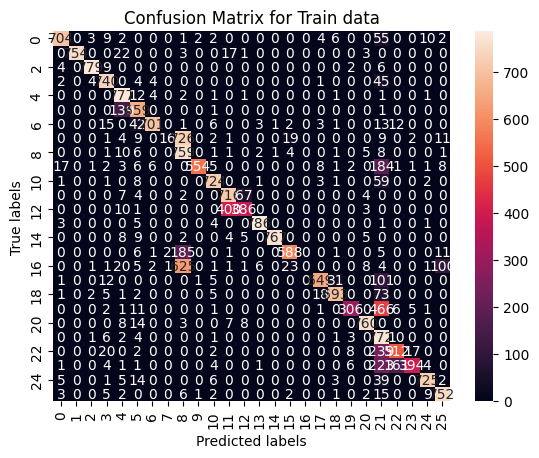

/Users/melloo21/opt/anaconda3/envs/cs4220_pathogen_detection/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 Macro Precision :  0.82, Recall :  0.77, F1 :  0.76
 Micro Precision :  0.77, Recall :  0.77, F1 :  0.77


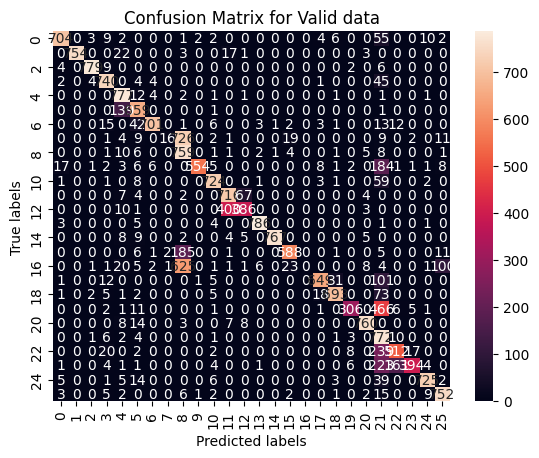

predicting for patient 0
Shape of (10054, 580)
my predition(s) for patient 0:
[]
true pathogen
['staphylococcus_aureus']
Jaccard index: 0.0
predicting for patient 1
Shape of (10132, 580)
my predition(s) for patient 1:
['neisseria_gonorrhoeae']
true pathogen
['staphylococcus_pyogenes']
Jaccard index: 0.0
predicting for patient 2
Shape of (10022, 580)
my predition(s) for patient 2:
['burkholderia_pseudomallei']
true pathogen
['burkholderia_pseudomallei' 'corynebacterium_ulcerans']
Jaccard index: 0.5
predicting for patient 3
Shape of (9984, 580)
my predition(s) for patient 3:
['klebsiella_pneumoniae', 'pseudomonas_aeruginosa']
true pathogen
['pseudomonas_aeruginosa']
Jaccard index: 0.5
predicting for patient 4
Shape of (10086, 580)
my predition(s) for patient 4:
[]
true pathogen
['corynebacterium_diphtheriae']
Jaccard index: 0.0
predicting for patient 5
Shape of (10046, 580)
my predition(s) for patient 5:
[]
true pathogen
['streptococcus_pneumoniae']
Jaccard index: 0.0
predicting for pati

In [162]:
print(f"model_name {model_name}")

performance_evaluate(
    train_dataset=(array_by_feature_impt, sampled_dataset.Y),
    valid_dataset=(array_by_feature_impt, sampled_dataset.Y),
    model_name=model_name,
    filepath="models"
)

all_jaccard_index, all_pred, all_true = get_all_jaccard_index_with_filter(
    model=model, label_encoder=label_encoder,filtered_idx=idx_keep_by_feature_impt_580 ,threshold=0.5)

print(['patient {}: {}'.format(c,item) for c, item in enumerate(all_jaccard_index)], 'avg: {}'.format(np.mean(all_jaccard_index)))

In [156]:
all_jaccard_index, all_pred, all_true = get_all_jaccard_index_with_filter(
    model=model, label_encoder=label_encoder,filtered_idx=idx_keep_by_feature_impt_1080 ,threshold=0.5)

print(['patient {}: {}'.format(c,item) for c, item in enumerate(all_jaccard_index)], 'avg: {}'.format(np.mean(all_jaccard_index)))

predicting for patient 0
Shape of (10054, 1080)
my predition(s) for patient 0:
['clostridioides_difficile', 'staphylococcus_pseudintermedius', 'staphylococcus_pyogenes', 'streptococcus_suis']
true pathogen
['staphylococcus_aureus']
Jaccard index: 0.0
predicting for patient 1
Shape of (10132, 1080)
my predition(s) for patient 1:
['campylobacter_jejuni', 'clostridioides_difficile', 'legionella_pneumophila', 'neisseria_gonorrhoeae', 'staphylococcus_aureus', 'staphylococcus_pseudintermedius', 'staphylococcus_pyogenes']
true pathogen
['staphylococcus_pyogenes']
Jaccard index: 0.14285714285714285
predicting for patient 2
Shape of (10022, 1080)
my predition(s) for patient 2:
['burkholderia_pseudomallei']
true pathogen
['burkholderia_pseudomallei' 'corynebacterium_ulcerans']
Jaccard index: 0.5
predicting for patient 3
Shape of (9984, 1080)
my predition(s) for patient 3:
['clostridioides_difficile', 'pseudomonas_aeruginosa']
true pathogen
['pseudomonas_aeruginosa']
Jaccard index: 0.5
predicting

In [ ]:
##### feature impt set Change param ####
# idx_keep_by_std_filter_0_0001
# idx_keep_by_std_filter_0_0002
# idx_keep_by_std_filter_0_0003

# Runnning for sampling rate of 3000 and toggling std dev set
filter_num = "0_0001"
array_by_std_filter = np.take(sampled_dataset.X, idx_keep_by_std_filter_0_0001, axis=1)

print("executing for this dataset" ,array_by_std_filter.shape)
# Runnning for sampling rate of 800 and toggling feature set
starting_time = timeit.default_timer()

model = OneVsRestClassifier(
    LogisticRegression(C=100, penalty='l1', solver='saga', n_jobs=-1, class_weight='balanced', max_iter=100, verbose=1)
    )

%timeit
# Train the model using the training sets
model.fit(array_by_std_filter, sampled_dataset.Y)

dump(model, f'models/ovr_std_impt_filtered_{filter_num}.joblib')
print("Time taken :", timeit.default_timer() - starting_time)

## OVO Modelling

In [17]:

# feature impt set 
# idx_keep_by_feature_impt_1080
# idx_keep_by_feature_impt_1580
# idx_keep_by_feature_impt_880
# idx_keep_by_feature_impt_580
filter_num = 1080,
model_type = "ovo"
array_by_feature_impt = np.take(sampled_dataset.X, idx_keep_by_feature_impt_1080, axis=1)

print("executing for this dataset" ,array_by_feature_impt.shape)
# Runnning for sampling rate of 800 and toggling feature set
starting_time = timeit.default_timer()

model = OneVsOneClassifier(
    LogisticRegression(C=100, penalty='l1', solver='saga', n_jobs=-1, class_weight='balanced', max_iter=150, verbose=1)
    )

%timeit
# Train the model using the training sets
model.fit(array_by_feature_impt, sampled_dataset.Y) 
model_name = f'{model_type}_feature_impt_filtered_{filter_num}.joblib'
dump(model, f"models/{model_name}")
print("Time taken :", timeit.default_timer() - starting_time)

executing for this dataset (20800, 1080)
Epoch 1, change: 1.00000000
Epoch 2, change: 0.33014430
Epoch 3, change: 0.17744665
Epoch 4, change: 0.11911153
Epoch 5, change: 0.08582351


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 6, change: 0.07021940
Epoch 7, change: 0.05741252
Epoch 8, change: 0.04938093
Epoch 9, change: 0.04287890
Epoch 10, change: 0.03757191
Epoch 11, change: 0.03364419
Epoch 12, change: 0.02991835
Epoch 13, change: 0.02714268
Epoch 14, change: 0.02476951
Epoch 15, change: 0.02266727
Epoch 16, change: 0.02087829
Epoch 17, change: 0.01941017
Epoch 18, change: 0.01814246
Epoch 19, change: 0.01693084
Epoch 20, change: 0.01585896
Epoch 21, change: 0.01500019
Epoch 22, change: 0.01412021
Epoch 23, change: 0.01339251
Epoch 24, change: 0.01271550
Epoch 25, change: 0.01207365
Epoch 26, change: 0.01148682
Epoch 27, change: 0.01099655
Epoch 28, change: 0.01051243
Epoch 29, change: 0.01007966
Epoch 30, change: 0.00967419
Epoch 31, change: 0.00930263
Epoch 32, change: 0.00893749
Epoch 33, change: 0.00861704
Epoch 34, change: 0.00832495
Epoch 35, change: 0.00801710
Epoch 36, change: 0.00776034
Epoch 37, change: 0.00750815
Epoch 38, change: 0.00726652
Epoch 39, change: 0.00704360
Epoch 40, change: 

/Users/melloo21/opt/anaconda3/envs/cs4220_pathogen_detection/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 9, change: 0.06909386
Epoch 10, change: 0.06066461
Epoch 11, change: 0.05439277
Epoch 12, change: 0.04901141
Epoch 13, change: 0.04418509
Epoch 14, change: 0.04064068
Epoch 15, change: 0.03708093
Epoch 16, change: 0.03410939
Epoch 17, change: 0.03164538
Epoch 18, change: 0.02944193
Epoch 19, change: 0.02748663
Epoch 20, change: 0.02568574
Epoch 21, change: 0.02420004
Epoch 22, change: 0.02275398
Epoch 23, change: 0.02144083
Epoch 24, change: 0.02035352
Epoch 25, change: 0.01916666
Epoch 26, change: 0.01830524
Epoch 27, change: 0.01744418
Epoch 28, change: 0.01658691
Epoch 29, change: 0.01581900
Epoch 30, change: 0.01518560
Epoch 31, change: 0.01454732
Epoch 32, change: 0.01391028
Epoch 33, change: 0.01334422
Epoch 34, change: 0.01286452
Epoch 35, change: 0.01235805
Epoch 36, change: 0.01191218
Epoch 37, change: 0.01147500
Epoch 38, change: 0.01110211
Epoch 39, change: 0.01071696
Epoch 40, change: 0.01037574
Epoch 41, change: 0.01003622
Epoch 42, change: 0.00972198
Epoch 43, chang

/Users/melloo21/opt/anaconda3/envs/cs4220_pathogen_detection/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 6, change: 0.11889426
Epoch 7, change: 0.10041755
Epoch 8, change: 0.08713742
Epoch 9, change: 0.07726272
Epoch 10, change: 0.06855355
Epoch 11, change: 0.06142297
Epoch 12, change: 0.05566803
Epoch 13, change: 0.05056623
Epoch 14, change: 0.04647229
Epoch 15, change: 0.04275905
Epoch 16, change: 0.03967259
Epoch 17, change: 0.03703397
Epoch 18, change: 0.03448949
Epoch 19, change: 0.03234628
Epoch 20, change: 0.03038986
Epoch 21, change: 0.02865168
Epoch 22, change: 0.02703722
Epoch 23, change: 0.02560685
Epoch 24, change: 0.02426453
Epoch 25, change: 0.02308940
Epoch 26, change: 0.02200003
Epoch 27, change: 0.02100592
Epoch 28, change: 0.02006743
Epoch 29, change: 0.01920061
Epoch 30, change: 0.01843834
Epoch 31, change: 0.01769594
Epoch 32, change: 0.01700207
Epoch 33, change: 0.01636371
Epoch 34, change: 0.01576085
Epoch 35, change: 0.01521490
Epoch 36, change: 0.01471326
Epoch 37, change: 0.01416440
Epoch 38, change: 0.01376762
Epoch 39, change: 0.01332412
Epoch 40, change: 

KeyboardInterrupt: 

Epoch 147, change: 0.00269259
Epoch 148, change: 0.00267121
Epoch 149, change: 0.00265096
max_iter reached after 4 secondsEpoch 150, change: 0.00263058



/Users/melloo21/opt/anaconda3/envs/cs4220_pathogen_detection/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


The data and labels are then accessible via `sampled_dataset.X` and `sampled_dataset.Y`.

## Quick Exploratory Data Analysis

We can use a [UMAP plot](https://www.scdiscoveries.com/blog/knowledge/what-is-a-umap-plot/) to try to group reads in the same species together, according to their $k$-mer profiles.

In [ ]:
# the last column of our 6mer training dataset can be ignored
# UMAP aims to find a low dimensional representation of the data [https://umap-learn.readthedocs.io/en/latest/parameters.html]
# UMAP hyperparameters that impact the data -- n_neighbours, min_dist, n_components, metric
# n_neighbors: controls how UMAP balances local versus global structure -- low neighbors will cause UMAP to 
# focus on very local structures -- (Default values : 15)

# min_dist: (Default values: 0.1) -- controls how tightly UMAP is allowed to pack points together , lower value of min_dist will 
# result in clumpier embeddings. This will be 

# n_component: (Default = 2) Number of dimensions, n=1 UMAP data will fall into a line
# metric: (Default)
mapper = UMAP(metric="euclidean").fit(sampled_dataset.X[:, :-1])

labels_tc = label_encoder.inverse_transform(sampled_dataset.Y)
ax = umap.plot.points(mapper, labels=labels_tc,  width=1500, height=1500)

In [ ]:
# Doing a UMAP for 2 coarse grained model

mapper = UMAP(metric="euclidean").fit(coarse_sampled_dataset.X[:, :-1])

coarse_labels_tc = coarse_label_encoder.inverse_transform(coarse_sampled_dataset.Y)
ax = umap.plot.points(mapper, labels=coarse_labels_tc,  width=1500, height=1500)

In [ ]:
# UMAP for the whole dataset
mapper = UMAP(metric="euclidean").fit(all_dataset.X[:, :-1])

labels_tc = le.inverse_transform(all_dataset.Y)
ax = umap.plot.points(mapper, labels=labels_tc,  width=1500, height=1500)

#### Just trying to integrate PCA into the UMAP to reduce the number of features and see if it cluster better but that doesn't seem to be the case 

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2080)  # Use the maximum number of components
pca.fit(sampled_dataset.X[:, :-1])
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='-')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance by Number of Components')
plt.grid(True)
plt.show()


In [ ]:
n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1
n_components_95

In [ ]:
sampled_X=sampled_dataset.X[:, :-1]
pca = PCA(n_components=1060)  # Specify the number of components to keep
sampled_X_pca = pca.fit_transform(sampled_X)
mapper_pca = UMAP().fit(sampled_X_pca)
labels_tc_pca = le.inverse_transform(sampled_dataset.Y)
ax = umap.plot.points(mapper_pca, labels=labels_tc_pca,  width=1500, height=1500)

What interesting patterns can you notice? Some observations might be:
- Some species are pretty separated in clusters.
- Even though most species lie in separate groups, we can see some regions where points from different species are overlapping.
- There are some "lost points" for pretty much every species.

Do you think these pieces of information can help you in something? Think about it.

Eugene's take on it:
- certain species have distinct genomic or sequence profiles that differentiate them from other species in the dataset
- the overlapping regions suggest shared genomic sequence between closely related species
- The "lost points" refer to data points that do not clearly belong to any specific cluster or group in the UMAP plot.


## Training

OK, time for training. As baseline we will choose the simplest [logistic regression](https://en.wikipedia.org/wiki/Logistic_regression) model.

You can fine-tune the logistic regression hyperparameters such as the penalty and regularization term.

```python
from sklearn.model_selection import GridSearchCV

#list of items to tune
parameters_lr = [{'penalty': ['l1','l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100]}]

starting_time = timeit.default_timer()

regr = LogisticRegression(random_state=2023, solver='saga', n_jobs=-1, class_weight='balanced', max_iter=50, verbose=1)

grid_search_lr = GridSearchCV(estimator = regr,
                              param_grid = parameters_lr,
                              scoring = 'accuracy',
                              cv = 3,
                              n_jobs = -1)

# the last column of our 6mer training dataset can be ignored (training labels)
grid_search_lr.fit(sampled_dataset.X, sampled_dataset.Y)
best_accuracy_lr = grid_search_lr.best_score_
best_parameter_lr = grid_search_lr.best_params_

```

This might take a long time. Here, we skip this step and jump straight to training.

In [ ]:
from sklearn.model_selection import train_test_split
# Having a training/validation set
X_train, X_test, y_train, y_test = train_test_split(sampled_dataset.X, sampled_dataset.Y,
                                                    stratify=sampled_dataset.Y, 
                                                    test_size=0.1)

In [ ]:
# Using a smaller lightweight model
from sklearn.naive_bayes import ComplementNB

clf = ComplementNB()
clf.fit(X_train, y_train)

dump(clf, 'models/nb_model.joblib')

In [ ]:
# linear classifier using scikit-learn
# Best Parameter of LR: {'C': 100, 'penalty': 'l1'}

starting_time = timeit.default_timer()

regr = LogisticRegression(C=100, penalty='l1', solver='saga', n_jobs=-1, class_weight='balanced', max_iter=100, verbose=1)
%timeit
# Train the model using the training sets
regr.fit(X_train, y_train)
dump(regr, 'models/log_reg.joblib')
print("Time taken :", timeit.default_timer() - starting_time)

In [ ]:
performance_evaluate(
    train_dataset=(X_train, y_train),
    valid_dataset=(X_test,y_test),
    model_name="log_reg",
    filepath="models"
)

all_jaccard_index, all_pred, all_true = get_all_jaccard_index(model=regr, label_encoder=label_encoder)

In [ ]:
np.mean(all_jaccard_index)

In [ ]:
# linear classifier using scikit-learn
# Best Parameter of LR: {'C': 100, 'penalty': 'l1'}

starting_time = timeit.default_timer()

regr = LogisticRegression(C=100, penalty='l1', solver='saga', n_jobs=-1, class_weight='balanced', max_iter=50, verbose=1)
%timeit
# Train the model using the training sets
regr.fit(sampled_dataset.X, sampled_dataset.Y)
print("Time taken :", timeit.default_timer() - starting_time)
dump(regr, 'models/log_reg_orig.joblib')

In [ ]:
performance_evaluate(
    train_dataset=(sampled_dataset.X, sampled_dataset.Y),
    valid_dataset=(sampled_dataset.X, sampled_dataset.Y),
    model_name="baseline",
    filepath="models"
)

baseline_model =_read_model(filepath="models", model_name="baseline")
all_jaccard_index, all_pred, all_true = get_all_jaccard_index(model=baseline_model, label_encoder=label_encoder)

In [ ]:
all_jaccard_index

We can now save our trained model for later usage. This is an example of how you can send your model to our final evaluation.

In [94]:
# Example usage
samples_500_index = create_sampling_idx(label_df,replace=False, sample_num=500,random_state=40)
display(samples_500_index)

input_file_path = './training_data/train_6mers.npy'

sampled_dataset = CS4220Dataset(
    data_file=input_file_path, 
    label_df=processed_label_df, 
    samples_index=samples_500_index)
print(len(sampled_dataset.X[:, :-1]), len(sampled_dataset.X[:, :-1][0])) # each row represent the sequence and each featuere represent the unique k-mers profile and the values represent the frequencies to it; exclude the last col as that is ambiguous
print(len(sampled_dataset.Y))

# linear classifier using scikit-learn
# Best Parameter of LR: {'C': 100, 'penalty': 'l1'}

starting_time = timeit.default_timer()

regr = LogisticRegression(C=100, penalty='l1', solver='saga', n_jobs=-1, class_weight='balanced', max_iter=50, verbose=1)
%timeit
# Train the model using the training sets
regr.fit(sampled_dataset.X, sampled_dataset.Y)
print("Time taken :", timeit.default_timer() - starting_time)
dump(regr, 'models/baseline.joblib')

Index([ 1604,  1901,   629,  1130,   485,  1672,   771,   408,  1682,  1058,
       ...
       46640, 46918, 46920, 47972, 47029, 46041, 46609, 46474, 47342, 46394],
      dtype='int64', length=13000)

13000 2080
13000


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.31215136
Epoch 3, change: 0.18996645
Epoch 4, change: 0.14280053
Epoch 5, change: 0.12051696
Epoch 6, change: 0.10450102
Epoch 7, change: 0.09361015
Epoch 8, change: 0.08463585
Epoch 9, change: 0.07739344
Epoch 10, change: 0.07090891
Epoch 11, change: 0.06364872
Epoch 12, change: 0.05761229
Epoch 13, change: 0.05262020
Epoch 14, change: 0.04833494
Epoch 15, change: 0.04428279
Epoch 16, change: 0.04126217
Epoch 17, change: 0.03912683
Epoch 18, change: 0.03717516
Epoch 19, change: 0.03548910
Epoch 20, change: 0.03379250
Epoch 21, change: 0.03221051
Epoch 22, change: 0.03095016
Epoch 23, change: 0.02963212
Epoch 24, change: 0.02840769
Epoch 25, change: 0.02723372
Epoch 26, change: 0.02625572
Epoch 27, change: 0.02524978
Epoch 28, change: 0.02428359
Epoch 29, change: 0.02341471
Epoch 30, change: 0.02257323
Epoch 31, change: 0.02178521
Epoch 32, change: 0.02104013
Epoch 33, change: 0.02030377
Epoch 34, change: 0.01963317
Epoch 35, change: 0.019

/Users/melloo21/opt/anaconda3/envs/cs4220_pathogen_detection/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


['models/baseline.joblib']

In [95]:
from joblib import dump, load
dump(regr, 'models/baseline.joblib')

['models/baseline.joblib']

### Trying out the GridSearchCV method he suggested but takes even longer and coef_ did not coverge as max_iter of 500 is reached

In [ ]:
from sklearn.model_selection import GridSearchCV

#list of items to tune
parameters_lr = [{'penalty': ['l1','l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100]}]

starting_time = timeit.default_timer()

regr = LogisticRegression(random_state=2023, solver='saga', n_jobs=-1, class_weight='balanced', max_iter=500, verbose=1)

grid_search_lr = GridSearchCV(estimator = regr,
                              param_grid = parameters_lr,
                              scoring = 'accuracy',
                              cv = 3,
                              n_jobs = -1)

# the last column of our 6mer training dataset can be ignored (training labels)
grid_search_lr.fit(sampled_dataset.X, sampled_dataset.Y)
best_accuracy_lr = grid_search_lr.best_score_
best_parameter_lr = grid_search_lr.best_params_

In [ ]:
np.random.random()

Then the model can be loaded using

```python
# load trained model
regr = load('models/baseline.joblib')
```

## Evaluation of Model

Now that you have your trained model, you can use it on each of the patient's read dataset and try to find the pathogens that appear in each patient.

Your model is evaluated based on [**Jaccard index**](https://en.wikipedia.org/wiki/Jaccard_index#Jaccard_index_in_binary_classification_confusion_matrices). For patient $i$, let $P$ be the set of pathogen species your model predicted (or $\{\text{decoy}\}$ if there is no pathogens predicted), and $T$ the set of pathogen species the patient actually have (or $\{\text{decoy}\}$ if there is no pathogens in the reads), the score for your model is

$$\text{Jaccard index}=\frac{|P\cap T|}{|P \cup T|}$$

Going back to our model: since we are using logistic regression, our model will classify each read to the class that has the highest probability of having the read. If we report all the species that a read has been classified to, then we may end up with a lot of false positives (why?).

One potential way to counter this is to define a threshold. Here I used 0.95: I only report a species if I am 95% confident that one read comes from that species. Let's see how well my model will behave...

In [96]:
# baseline_model =_read_model(filepath="models", model_name="baseline")
baseline_model = load('models/baseline.joblib')
all_jaccard_index, all_pred, all_true = get_all_jaccard_index(model=baseline_model, label_encoder=label_encoder)

predicting for patient 0
my predition(s) for patient 0:
[]
true pathogen
['staphylococcus_aureus']
Jaccard index: 0.0
predicting for patient 1
my predition(s) for patient 1:
[]
true pathogen
['staphylococcus_pyogenes']
Jaccard index: 0.0
predicting for patient 2
my predition(s) for patient 2:
['burkholderia_pseudomallei', 'clostridioides_difficile']
true pathogen
['burkholderia_pseudomallei' 'corynebacterium_ulcerans']
Jaccard index: 0.3333333333333333
predicting for patient 3
my predition(s) for patient 3:
['clostridioides_difficile']
true pathogen
['pseudomonas_aeruginosa']
Jaccard index: 0.0
predicting for patient 4
my predition(s) for patient 4:
[]
true pathogen
['corynebacterium_diphtheriae']
Jaccard index: 0.0
predicting for patient 5
my predition(s) for patient 5:
[]
true pathogen
['streptococcus_pneumoniae']
Jaccard index: 0.0
predicting for patient 6
my predition(s) for patient 6:
[]
true pathogen
['mycobacterium_ulcerans']
Jaccard index: 0.0
predicting for patient 7
my predit

In [97]:
all_jaccard_index

[0.0, 0.0, 0.3333333333333333, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]

In [98]:
print(['patient {}: {}'.format(c,item) for c, item in enumerate(all_jaccard_index)], 'avg: {}'.format(np.mean(all_jaccard_index)))

['patient 0: 0.0', 'patient 1: 0.0', 'patient 2: 0.3333333333333333', 'patient 3: 0.0', 'patient 4: 0.0', 'patient 5: 0.0', 'patient 6: 0.0', 'patient 7: 0.0', 'patient 8: 0.0', 'patient 9: 1.0'] avg: 0.13333333333333333


In [ ]:
set(all_true)

In [ ]:
set(all_pred)

So the overall score for my model is 0.45. Not a bad start, but still much room for improvement. You don't necessarily need to work on this baseline; this was just released as an example. Have fun!!!